In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
from ieeg.auth import Session
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from iEEG_helper_functions import *

In [2]:
SPIKES_OUTPUT_DIR = "../../Data/spikes/devin_spikes/"
SEIZURES_DIR = "../../Data/seizures/source_mat/"
SOZ_DIR = "../../Data/seizure_onset_zones/"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"
SEIZURE_BUFFER_TIME_MINUTES = 30  # minutes

In [3]:
# Initialize an empty list to hold the data
# completed_hup_ids = [160, 172, 141, 145, 157, 161, 138, 142, 151, 171, 175, 187]
completed_hup_ids = [
    160,
    172,
    # 141, # not enough time before first seizure
    145,
    138,
    142,
    151,
    187,
    180,
    184,
    # 192, # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    # 165, # incomplete data
    # 169, # not enough time after the last seizure
    173,
    # 150, # not enough time before first seizure
    # 154, # incomplete data
    # 158, # incomplete data
    # 207, # not enough time before first seizure
    223,
    # 192,  ## Monday, August 21, 2023 additions this line and below # incomplete data
    # 196, # not enough time before first seizure
    # 204, # not enough time before first seizure
    177,
    185,
    # 189, # not enough time before first seizure
    # 205, # not enough time before first seizure
    166,
    # 170, # not enough time before first seizure
    # 174, # not enough time before first seizure
]
# Sort completed_hup_ids in ascending order
completed_hup_ids.sort()

In [4]:
with open("dma_ieeglogin.bin", "r") as f:
    session = Session("dma", f.read())
# Initialize a dataframe with hup_id, dataset_name, fs
patients_df = pd.DataFrame(columns=["hup_id", "dataset_name", "fs"])
for patient_hup_id in completed_hup_ids:
    dataset_name = f"HUP{patient_hup_id}_phaseII"
    dataset = session.open_dataset(dataset_name)
    all_channel_labels = np.array(dataset.get_channel_labels())
    channel_labels_to_download = all_channel_labels[
        electrode_selection(all_channel_labels)
    ]

    fs = int(dataset.get_time_series_details(channel_labels_to_download[0]).sample_rate)
    # Construct a row and add it to the dataframe
    row_df = pd.DataFrame(
        [{"hup_id": patient_hup_id, "dataset_name": dataset_name, "fs": fs}]
    )
    patients_df = pd.concat([patients_df, row_df], ignore_index=True)
# Sort the dataframe by hup_id
patients_df = patients_df.sort_values(by="hup_id")
# reset the index
patients_df = patients_df.reset_index(drop=True)
patients_df

,hup_id,dataset_name,fs
0,138,HUP138_phaseII,1024
1,142,HUP142_phaseII,512
2,145,HUP145_phaseII,512
3,151,HUP151_phaseII,512
4,160,HUP160_phaseII,1024
5,166,HUP166_phaseII,1024
6,172,HUP172_phaseII,512
7,173,HUP173_phaseII,256
8,177,HUP177_phaseII,512
9,180,HUP180_phaseII,512


In [5]:
# def format_channels(channel_array):
#     formatted_array = []
#     for label in channel_array:
#         if label == "PZ":
#             formatted_array.append(label)
#             continue

#         # Splitting string into two parts: prefix (letters) and number
#         prefix, number = (
#             label[: -len([ch for ch in label if ch.isdigit()])],
#             label[-len([ch for ch in label if ch.isdigit()]) :],
#         )

#         # Formatting the number to have two digits
#         formatted_number = f"{int(number):02}"

#         # Appending prefix and formatted number
#         formatted_label = prefix + formatted_number
#         formatted_array.append(formatted_label)

#     return np.array(formatted_array)

In [6]:
all_spikes_dfs = []
all_fs = []

In [7]:
for index, row in patients_df.iterrows():
    patient_hup_id = row["hup_id"]
    fs = row["fs"]
    all_fs.append(fs)
    print(f"Processing HUP {patient_hup_id} with fs {fs}")

    ###############################
    # Construct spike_files_df
    ###############################

    # Initialize an empty list to hold the data
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(SPIKES_OUTPUT_DIR):
        # Check if the file ends with .npy
        if filename.endswith(".npy"):
            # Use regular expression to match the pattern and extract desired numbers
            match = re.match(r"HUP(\d+)_phaseII_(\d+).npy", filename)

            if match:
                current_patient_hup_id = int(match.group(1))
                if current_patient_hup_id != patient_hup_id:
                    continue
                interval_index = int(match.group(2))

                # Append the data to the list
                data.append(
                    {
                        "filename": filename,
                        "interval_index": interval_index,
                    }
                )

    # Convert the list of dictionaries to a pandas DataFrame
    spike_files_df = pd.DataFrame(data)
    # Sort the DataFrame by the interval index
    spike_files_df = spike_files_df.sort_values(by="interval_index")
    # Reset the index
    spike_files_df = spike_files_df.reset_index(drop=True)
    # Add a new column called "start_sample_index"
    spike_files_df["start_sample_index"] = (
        spike_files_df["interval_index"] * fs * 60 * 2
    )

    ###############################
    # Construct all_spikes_df
    ###############################
    # Initialize an empty list to store individual DataFrames
    dfs = []

    for index, row in spike_files_df.iterrows():
        filename = row["filename"]
        start_sample_index = row["start_sample_index"]

        # Load the data
        spike_data = np.load(os.path.join(SPIKES_OUTPUT_DIR, filename))

        # Adjust the start_sample_index
        spike_data[:, 0] += start_sample_index

        # Convert the modified spike_data to a DataFrame and append to the dfs list
        dfs.append(
            pd.DataFrame(
                spike_data,
                columns=[
                    "peak_index",
                    "channel_index",
                    "peak",
                    "left_point",
                    "right_point",
                    "slow_end",
                    "slow_max",
                    "rise_amp",
                    "decay_amp",
                    "slow_width",
                    "slow_amp",
                    "rise_slope",
                    "decay_slope",
                    "average_amp",
                    "linelen",
                ],
            )
        )

    # Concatenate all the individual DataFrames into a single DataFrame
    all_spikes_df = pd.concat(dfs, ignore_index=True)
    # Drop any rows with any NaN values
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)
    # Make peak_index and channel_index integers
    all_spikes_df["peak_index"] = all_spikes_df["peak_index"].astype(int)
    all_spikes_df["channel_index"] = all_spikes_df["channel_index"].astype(int)

    ###############################
    # ISI
    ###############################
    # Calculate the inter-spike interval
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df["peak_index"].diff()

    # Drop the first row and reset index
    all_spikes_df = all_spikes_df.dropna().reset_index(drop=True)

    # Convert the inter_spike_interval_samples column to integer
    all_spikes_df["inter_spike_interval_samples"] = all_spikes_df[
        "inter_spike_interval_samples"
    ].astype(int)

    all_spikes_df["inter_spike_interval_sec"] = (
        all_spikes_df["inter_spike_interval_samples"] / fs
    ).astype(int)

    all_spikes_dfs.append(all_spikes_df)

Processing HUP 138 with fs 1024
Processing HUP 142 with fs 512
Processing HUP 145 with fs 512
Processing HUP 151 with fs 512
Processing HUP 160 with fs 1024
Processing HUP 166 with fs 1024
Processing HUP 172 with fs 512
Processing HUP 173 with fs 256
Processing HUP 177 with fs 512
Processing HUP 180 with fs 512
Processing HUP 184 with fs 512
Processing HUP 185 with fs 512
Processing HUP 187 with fs 512
Processing HUP 223 with fs 1024


## Interspike Interval (ISI) Distribution

In [8]:
thresholds = [4.6, 4, 4.3, 4, 5.5, 4.1, 4, 3, 4, 4, 4, 3.7, 4, 5]
thresholds = np.exp(thresholds)
thresholds, len(thresholds)

(array([ 99.48431564,  54.59815003,  73.6997937 ,  54.59815003,
        244.69193226,  60.3402876 ,  54.59815003,  20.08553692,
         54.59815003,  54.59815003,  54.59815003,  40.44730436,
         54.59815003, 148.4131591 ]),
 14)

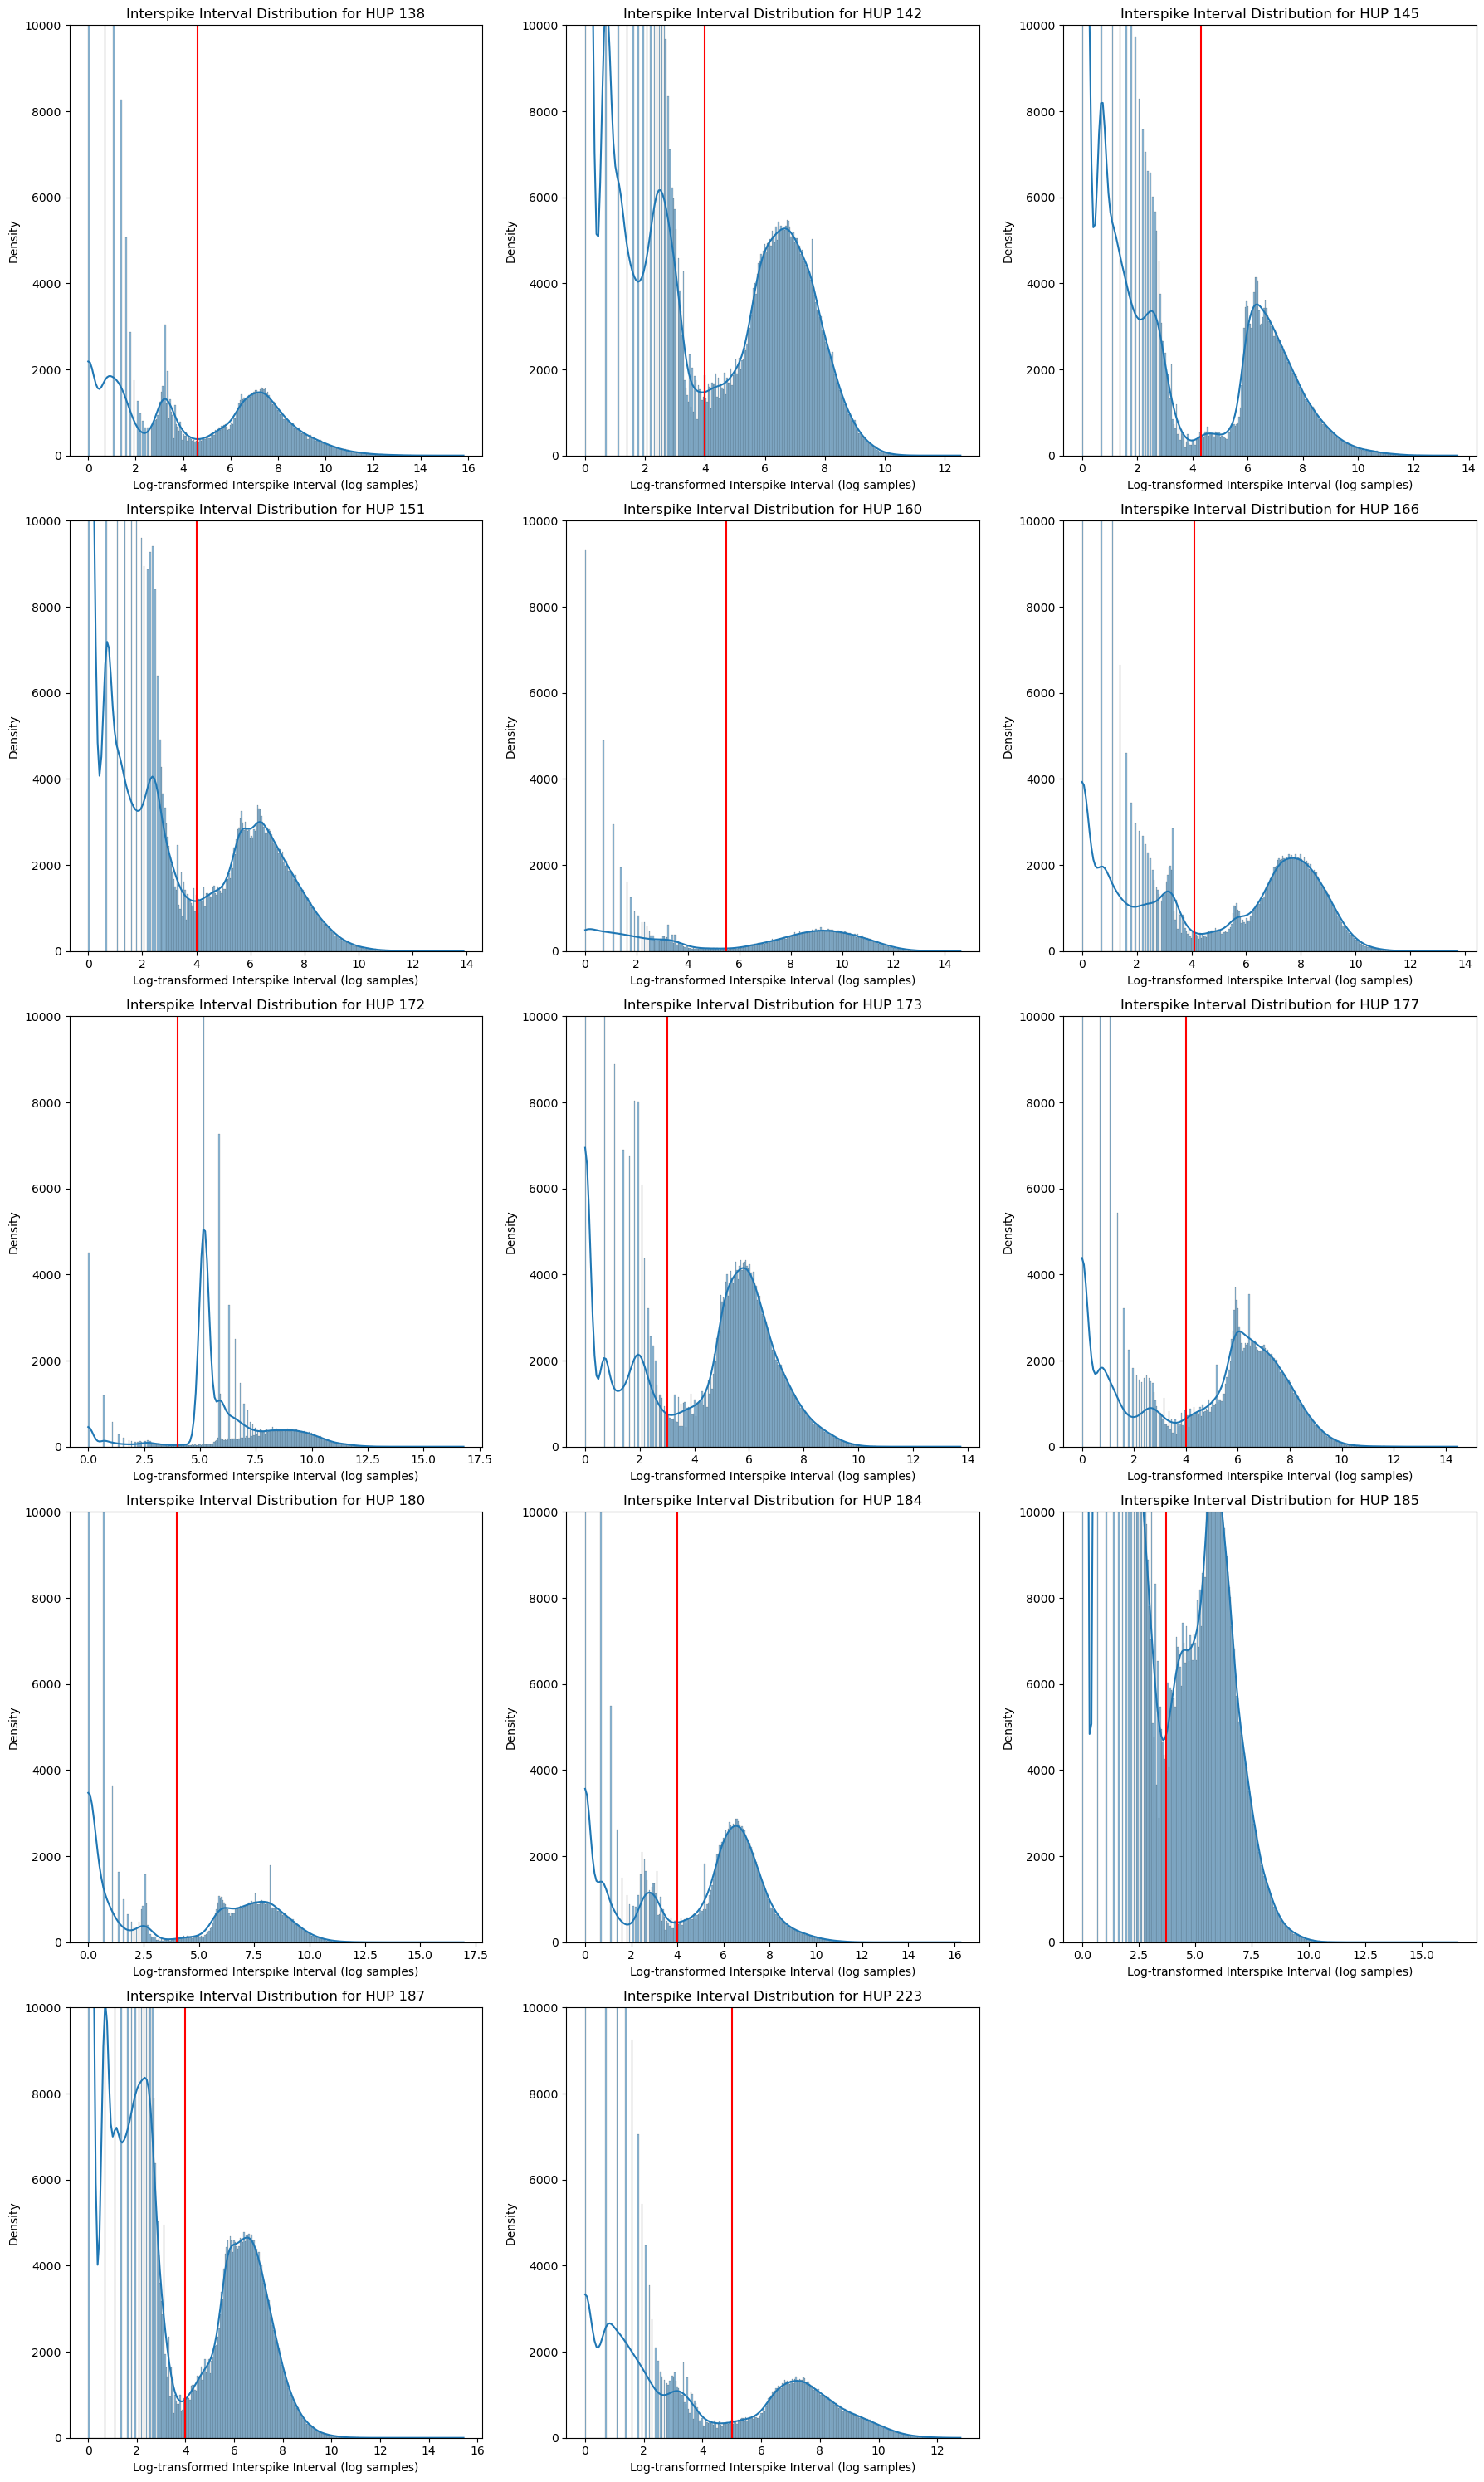

In [9]:
# Determine number of rows
num_plots = len(completed_hup_ids)
num_columns = 3
num_rows = (num_plots + 2) // num_columns  # ceil division

# Create a main figure and axes
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, 6 * num_rows))

# If there's only one row, axes is 1D and we should reshape it
if num_rows == 1:
    axes = axes.reshape(1, -1)

for idx, (hup_id, all_spikes_df) in enumerate(zip(completed_hup_ids, all_spikes_dfs)):
    # Find the row in patients_df that corresponds to the current hup_id
    patient_row = patients_df[patients_df["hup_id"] == hup_id]

    # Visualize with log transformation (excluding zeros to avoid -inf)
    log_data = np.log(
        all_spikes_df[all_spikes_df["inter_spike_interval_samples"] > 0][
            "inter_spike_interval_samples"
        ]
    )

    ax = axes[idx // num_columns, idx % num_columns]
    sns.histplot(log_data, kde=True, bins=300, ax=ax)
    # plot a vertical line at the threshold
    ax.axvline(np.log(thresholds[idx]), color="red", label="Threshold")
    ax.set_title(f"Interspike Interval Distribution for HUP {hup_id}")
    ax.set_xlabel("Log-transformed Interspike Interval (log samples)")
    ax.set_ylabel("Density")
    ax.set_ylim(0, 10000)

# Remove any unused subplots
for idx in range(num_plots, num_rows * num_columns):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

## ISI Changes over time

In [10]:
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    print(f"HUP {hup_id} with fs {fs}")
    # Convert peak_index to second
    all_spikes_df["peak_second"] = all_spikes_df["peak_index"] // fs
    # Convert peak_index to minute
    all_spikes_df["peak_minute"] = all_spikes_df["peak_index"] / fs // 60
    # Convert peak_index to hour
    all_spikes_df["peak_hour"] = all_spikes_df["peak_index"] / fs // 3600

HUP 138 with fs 1024
HUP 142 with fs 512
HUP 145 with fs 512
HUP 151 with fs 512
HUP 160 with fs 1024
HUP 166 with fs 1024


HUP 172 with fs 512
HUP 173 with fs 256
HUP 177 with fs 512
HUP 180 with fs 512
HUP 184 with fs 512
HUP 185 with fs 512
HUP 187 with fs 512
HUP 223 with fs 1024


- there seems to be a dichotomy between 50 samples regardless of sampling rate. Why regardless of sampling rate???
- less than 50 samples of delay could mean they're distrinct spikes.
- while greater than that might be propogation?
- or the other way around?

HUP 138
9.57910906298003 9.704869358669834 12.922890397672163
HUP 142
3.941431544865865 3.789310851573981 4.023183925811438
HUP 145
4.228472736244757 3.1713286713286712 7.634887005649717
HUP 151
3.451682953311618 2.6507825703578516 3.760514765415264
HUP 160
21.71608832807571 10.242327072835547 16.833333333333332
HUP 166
7.888682745825603 5.277456053181647 12.712899543378995
HUP 172
4.599508599508599 1.505952380952381 2.085889570552147
HUP 173
2.3526297211436638 2.5209183673469386 2.0918070889018012
HUP 177
1.894736842105263 4.151890886546807 3.4114717223650386
HUP 180
1.0158450704225352 1.050381436745073 1.9461538461538461
HUP 184
2.671641791044776 4.20372526193248 5.051113032202291
HUP 185
4.798310776432278 3.5143365983971506 4.41472493113973
HUP 187
4.046899310957991 4.280727539959581 4.348061903384437
HUP 223
7.3584327086882455 11.012336160370085 14.058985200845665


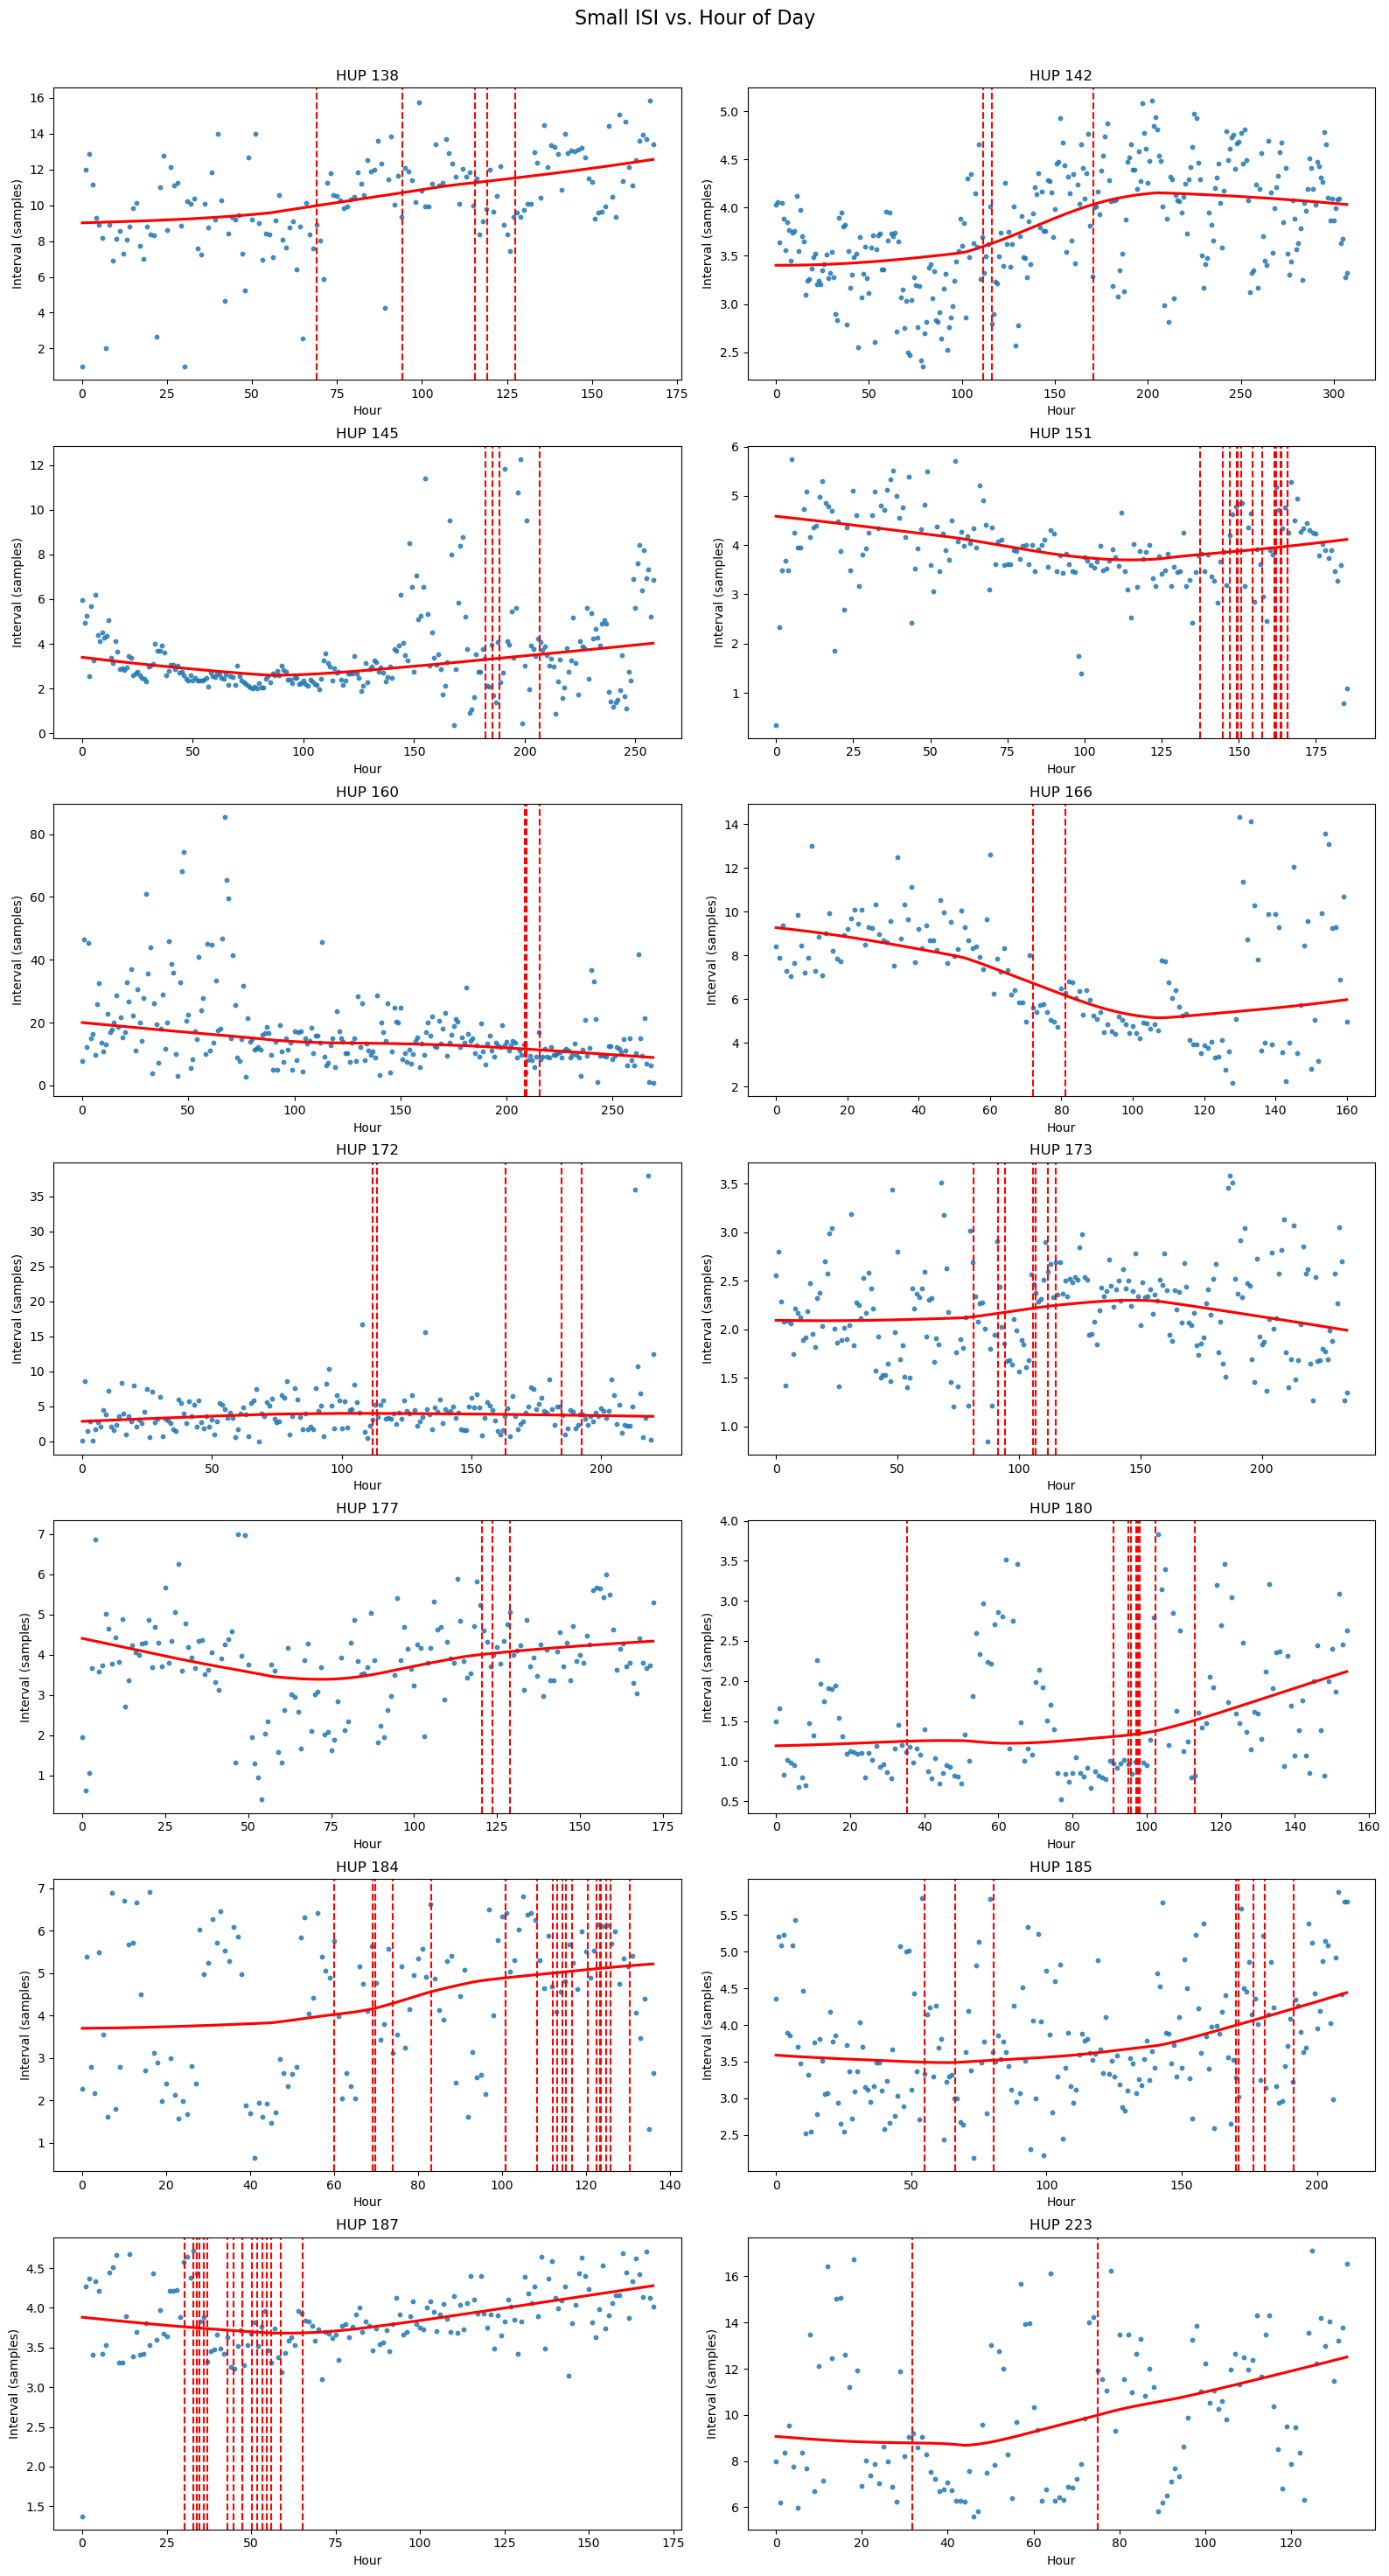

In [11]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

max_medication_fanos = []
before_seizure_fanos = []
after_seizure_fanos = []

# Looping over the dataframes
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    print(f"HUP {hup_id}")
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples < threshold]

    # Load seizure times and convert to hours
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours

    # Extracting Fano Factors for the three scenarios:

    # 1. Max medication
    max_medication_data = filtered_df[filtered_df["peak_hour"].isin(range(1, 6))][
        "inter_spike_interval_samples"
    ]
    max_medication_fano = max_medication_data.mean()
    max_medication_fanos.append(max_medication_fano)

    # 2. Before seizure
    first_seizure_hour = int(seizure_times_hour[0])
    before_seizure_data = filtered_df[
        filtered_df["peak_hour"].isin(
            range(first_seizure_hour - 4, first_seizure_hour + 1)
        )
    ]["inter_spike_interval_samples"]
    before_seizure_fano = before_seizure_data.mean()
    before_seizure_fanos.append(before_seizure_fano)

    # 3. After seizure
    last_hours = sorted(filtered_df["peak_hour"].unique())[-9:-4]
    assert len(last_hours) == 5
    after_seizure_data = filtered_df[filtered_df["peak_hour"].isin(last_hours)][
        "inter_spike_interval_samples"
    ]
    after_seizure_fano = after_seizure_data.mean()
    after_seizure_fanos.append(after_seizure_fano)

    print(max_medication_fano, before_seizure_fano, after_seizure_fano)

    # Group by peak_hour and take the mean
    grouped = filtered_df.groupby("peak_hour").mean()
    # Find the indices of the two largest inter_spike_interval_samples
    indices_to_drop = grouped["inter_spike_interval_samples"].nlargest(2).index
    # Drop those rows
    grouped.drop(indices_to_drop, inplace=True)
    # Reset the index
    grouped.reset_index(inplace=True)

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting using seaborn's regplot
    sns.regplot(
        x=grouped.index,
        y=grouped["inter_spike_interval_samples"],
        ax=axarr[row, col],
        lowess=True,
        scatter_kws={"s": 10},
        line_kws={"color": "red"},
    )

    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Interval (samples)")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
# Add a title
fig.suptitle("Small ISI vs. Hour of Day", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

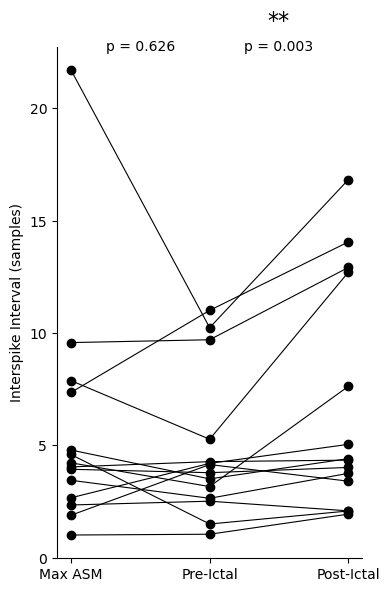

In [12]:
plt.figure(figsize=(4, 6))

for i in range(len(completed_hup_ids)):
    plt.plot(
        [0, 1, 2],
        [max_medication_fanos[i], before_seizure_fanos[i], after_seizure_fanos[i]],
        marker="o",
        color="black",
        linewidth=0.8,
    )

plt.xticks([0, 1, 2], ["Max ASM", "Pre-Ictal", "Post-Ictal"])
plt.ylabel("Interspike Interval (samples)")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 3. Run statistical tests
w1, p1 = wilcoxon(max_medication_fanos, before_seizure_fanos)
w2, p2 = wilcoxon(before_seizure_fanos, after_seizure_fanos)

# Add p-values to the plot
significance_marker = "**"  # using a star as the significance marker
alpha = 0.05  # typical threshold for significance

if p1 < alpha:
    plt.text(
        0.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    0.5,
    plt.ylim()[1],
    f"p = {p1:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

if p2 < alpha:
    plt.text(
        1.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    1.5,
    plt.ylim()[1],
    f"p = {p2:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

plt.tight_layout()
plt.show()

25193.088528678305 12772.808731808731 10927.562351543944
1711.0047132757265 2414.6019494204425 1605.531638913234
3138.562265438417 11185.39563106796 5280.478211009175
10168.449691991786 2186.540282094191 959.9510886715052
25333.7208994709 15354.3675 53455.702623906705
5588.28805186786 2197.1393640086726 4759.610852713178
14222.631756756757 17694.05172413793 1191.095721604283
1001.3562568008705 2306.771543086172 1520.2395110670632
43234.283105022834 1817.363564512942 1599.1622845202855
5574.623361823362 3910.3744680851064 11683.076826196473
4728.137727759914 4663.33400707428 1098.1088753144088
1605.8576431448082 1620.2689789417802 757.0910301214844
4668.077075098814 2172.5512911632313 1479.420908062692
11934.428015564203 13301.202458423717 3049.2750458409737


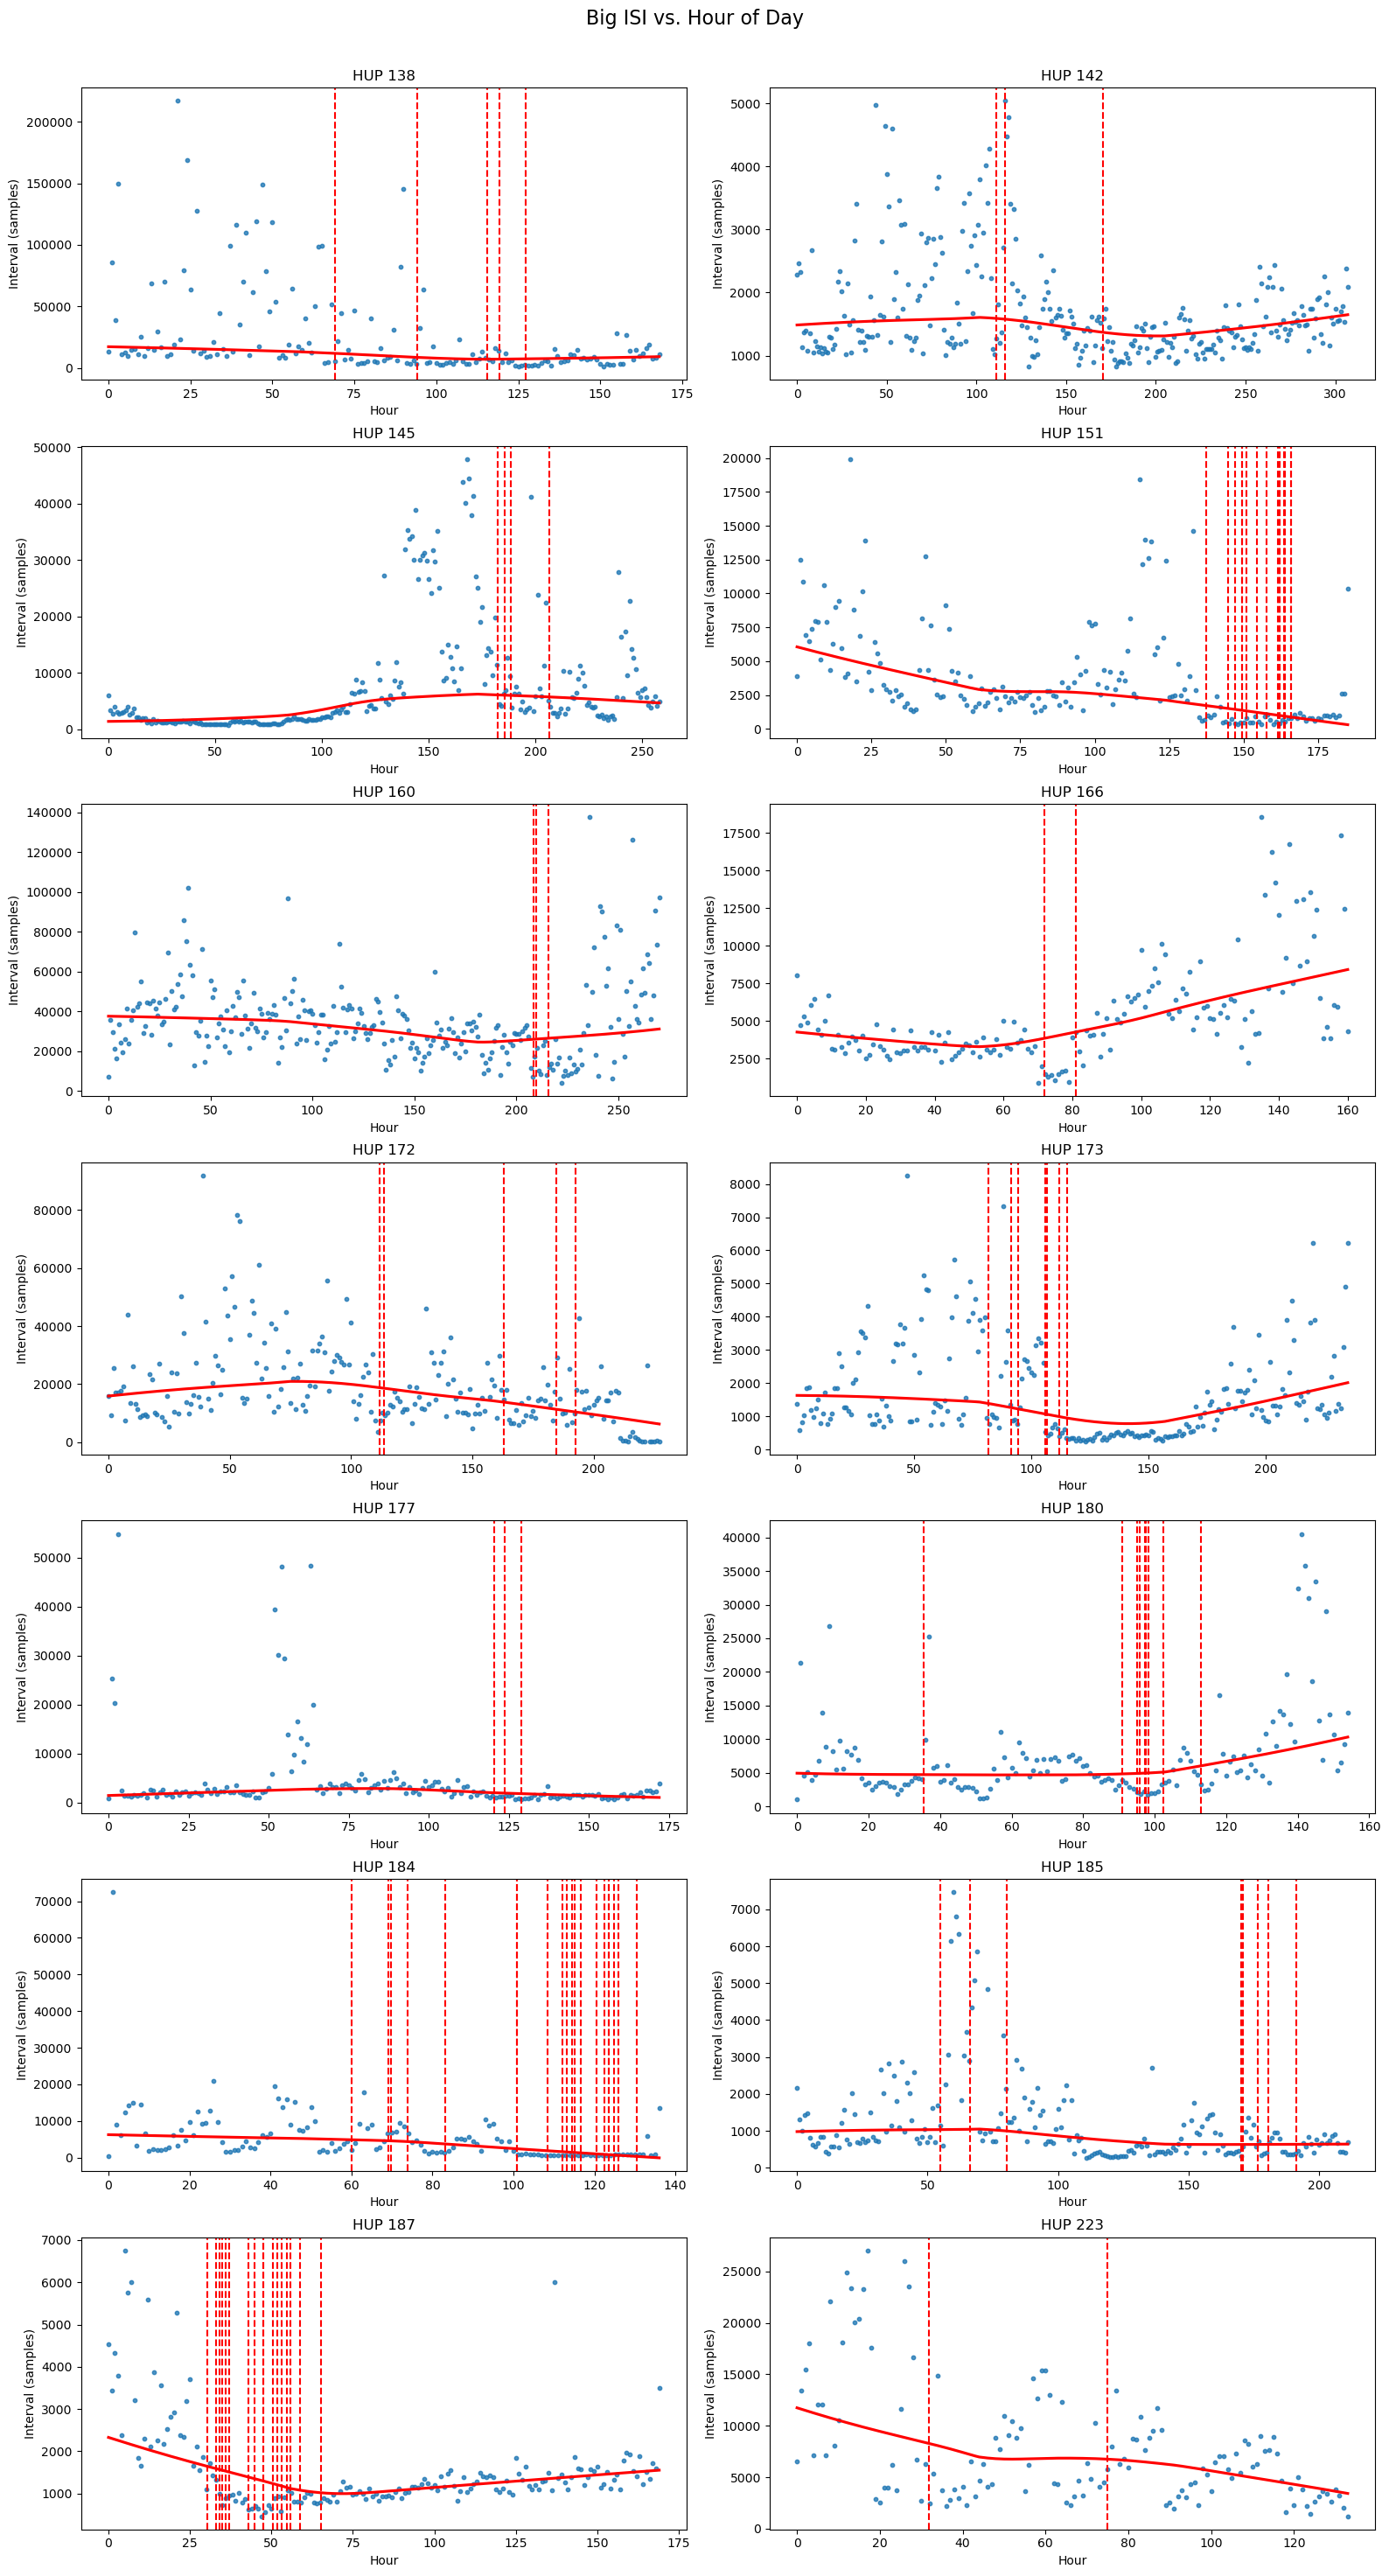

In [13]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

max_medication_fanos = []
before_seizure_fanos = []
after_seizure_fanos = []

# Looping over the dataframes
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples > threshold]

    # Load seizure times and plot vertical lines
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours

    # Extracting Fano Factors for the three scenarios:

    # 1. Max medication
    max_medication_data = filtered_df[filtered_df["peak_hour"].isin(range(1, 6))][
        "inter_spike_interval_samples"
    ]
    max_medication_fano = max_medication_data.mean()
    max_medication_fanos.append(max_medication_fano)

    # 2. Before seizure
    first_seizure_hour = int(seizure_times_hour[0])
    before_seizure_data = filtered_df[
        filtered_df["peak_hour"].isin(
            range(first_seizure_hour - 4, first_seizure_hour + 1)
        )
    ]["inter_spike_interval_samples"]
    before_seizure_fano = before_seizure_data.mean()
    before_seizure_fanos.append(before_seizure_fano)

    # 3. After seizure
    last_hours = sorted(filtered_df["peak_hour"].unique())[-9:-4]
    assert len(last_hours) == 5
    after_seizure_data = filtered_df[filtered_df["peak_hour"].isin(last_hours)][
        "inter_spike_interval_samples"
    ]
    after_seizure_fano = after_seizure_data.mean()
    after_seizure_fanos.append(after_seizure_fano)

    print(max_medication_fano, before_seizure_fano, after_seizure_fano)

    # Group by peak_hour and take the mean
    grouped = filtered_df.groupby("peak_hour").mean()
    # Find the indices of the two largest inter_spike_interval_samples
    indices_to_drop = grouped["inter_spike_interval_samples"].nlargest(2).index
    # Drop those rows
    grouped.drop(indices_to_drop, inplace=True)
    # Reset the index
    grouped.reset_index(inplace=True)

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting using seaborn's regplot
    sns.regplot(
        x=grouped.index,
        y=grouped["inter_spike_interval_samples"],
        ax=axarr[row, col],
        lowess=True,
        scatter_kws={"s": 10},
        line_kws={"color": "red"},
    )

    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Interval (samples)")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
fig.suptitle("Big ISI vs. Hour of Day", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

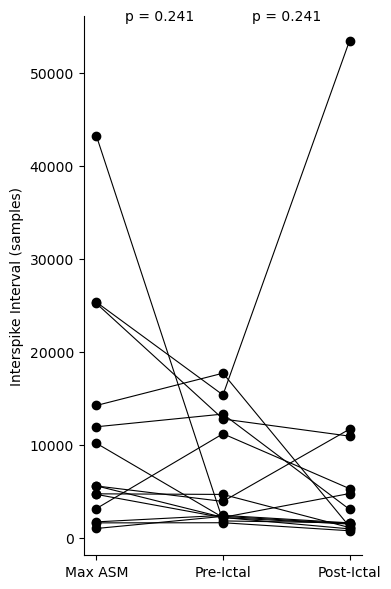

In [14]:
plt.figure(figsize=(4, 6))

for i in range(len(completed_hup_ids)):
    plt.plot(
        [0, 1, 2],
        [max_medication_fanos[i], before_seizure_fanos[i], after_seizure_fanos[i]],
        marker="o",
        color="black",
        linewidth=0.8,
    )

plt.xticks([0, 1, 2], ["Max ASM", "Pre-Ictal", "Post-Ictal"])
plt.ylabel("Interspike Interval (samples)")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 3. Run statistical tests
w1, p1 = wilcoxon(max_medication_fanos, before_seizure_fanos)
w2, p2 = wilcoxon(before_seizure_fanos, after_seizure_fanos)

# Add p-values to the plot
significance_marker = "**"  # using a star as the significance marker
alpha = 0.05  # typical threshold for significance

if p1 < alpha:
    plt.text(
        0.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    0.5,
    plt.ylim()[1],
    f"p = {p1:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

if p2 < alpha:
    plt.text(
        1.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    1.5,
    plt.ylim()[1],
    f"p = {p2:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

plt.tight_layout()
plt.show()

## Small ISI Heterogenity and how it changes over time

Processing HUP 138...
[163.0, 164.0, 165.0, 166.0, 167.0]
25.048669369616174 32.08013544604866 27.098094542687498
Processing HUP 142...
[302.0, 303.0, 304.0, 305.0, 306.0]
14.695749724913304 14.428983480229569 15.66344170591126
Processing HUP 145...
[252.0, 253.0, 254.0, 255.0, 256.0]
26.69606450865727 24.406786527649146 29.944765653880623
Processing HUP 151...
[179.0, 180.0, 181.0, 182.0, 183.0]
13.53614907959146 12.936395236274542 14.849582257444965
Processing HUP 160...
[264.0, 265.0, 266.0, 267.0, 268.0]
97.11839807974528 62.031403681012065 103.70095653633162
Processing HUP 166...
[155.0, 156.0, 157.0, 158.0, 159.0]
18.06703187229527 16.815074014693778 20.05089091870541
Processing HUP 172...
[216.0, 217.0, 220.0, 221.0, 222.0]
20.277647651953774 14.991508685528759 25.21586782861296
Processing HUP 173...
[229.0, 230.0, 231.0, 232.0, 233.0]
6.083010875467905 6.230084574290932 5.54474806201554
Processing HUP 177...
[166.0, 167.0, 168.0, 169.0, 170.0]
18.73613076475838 17.5891886212887

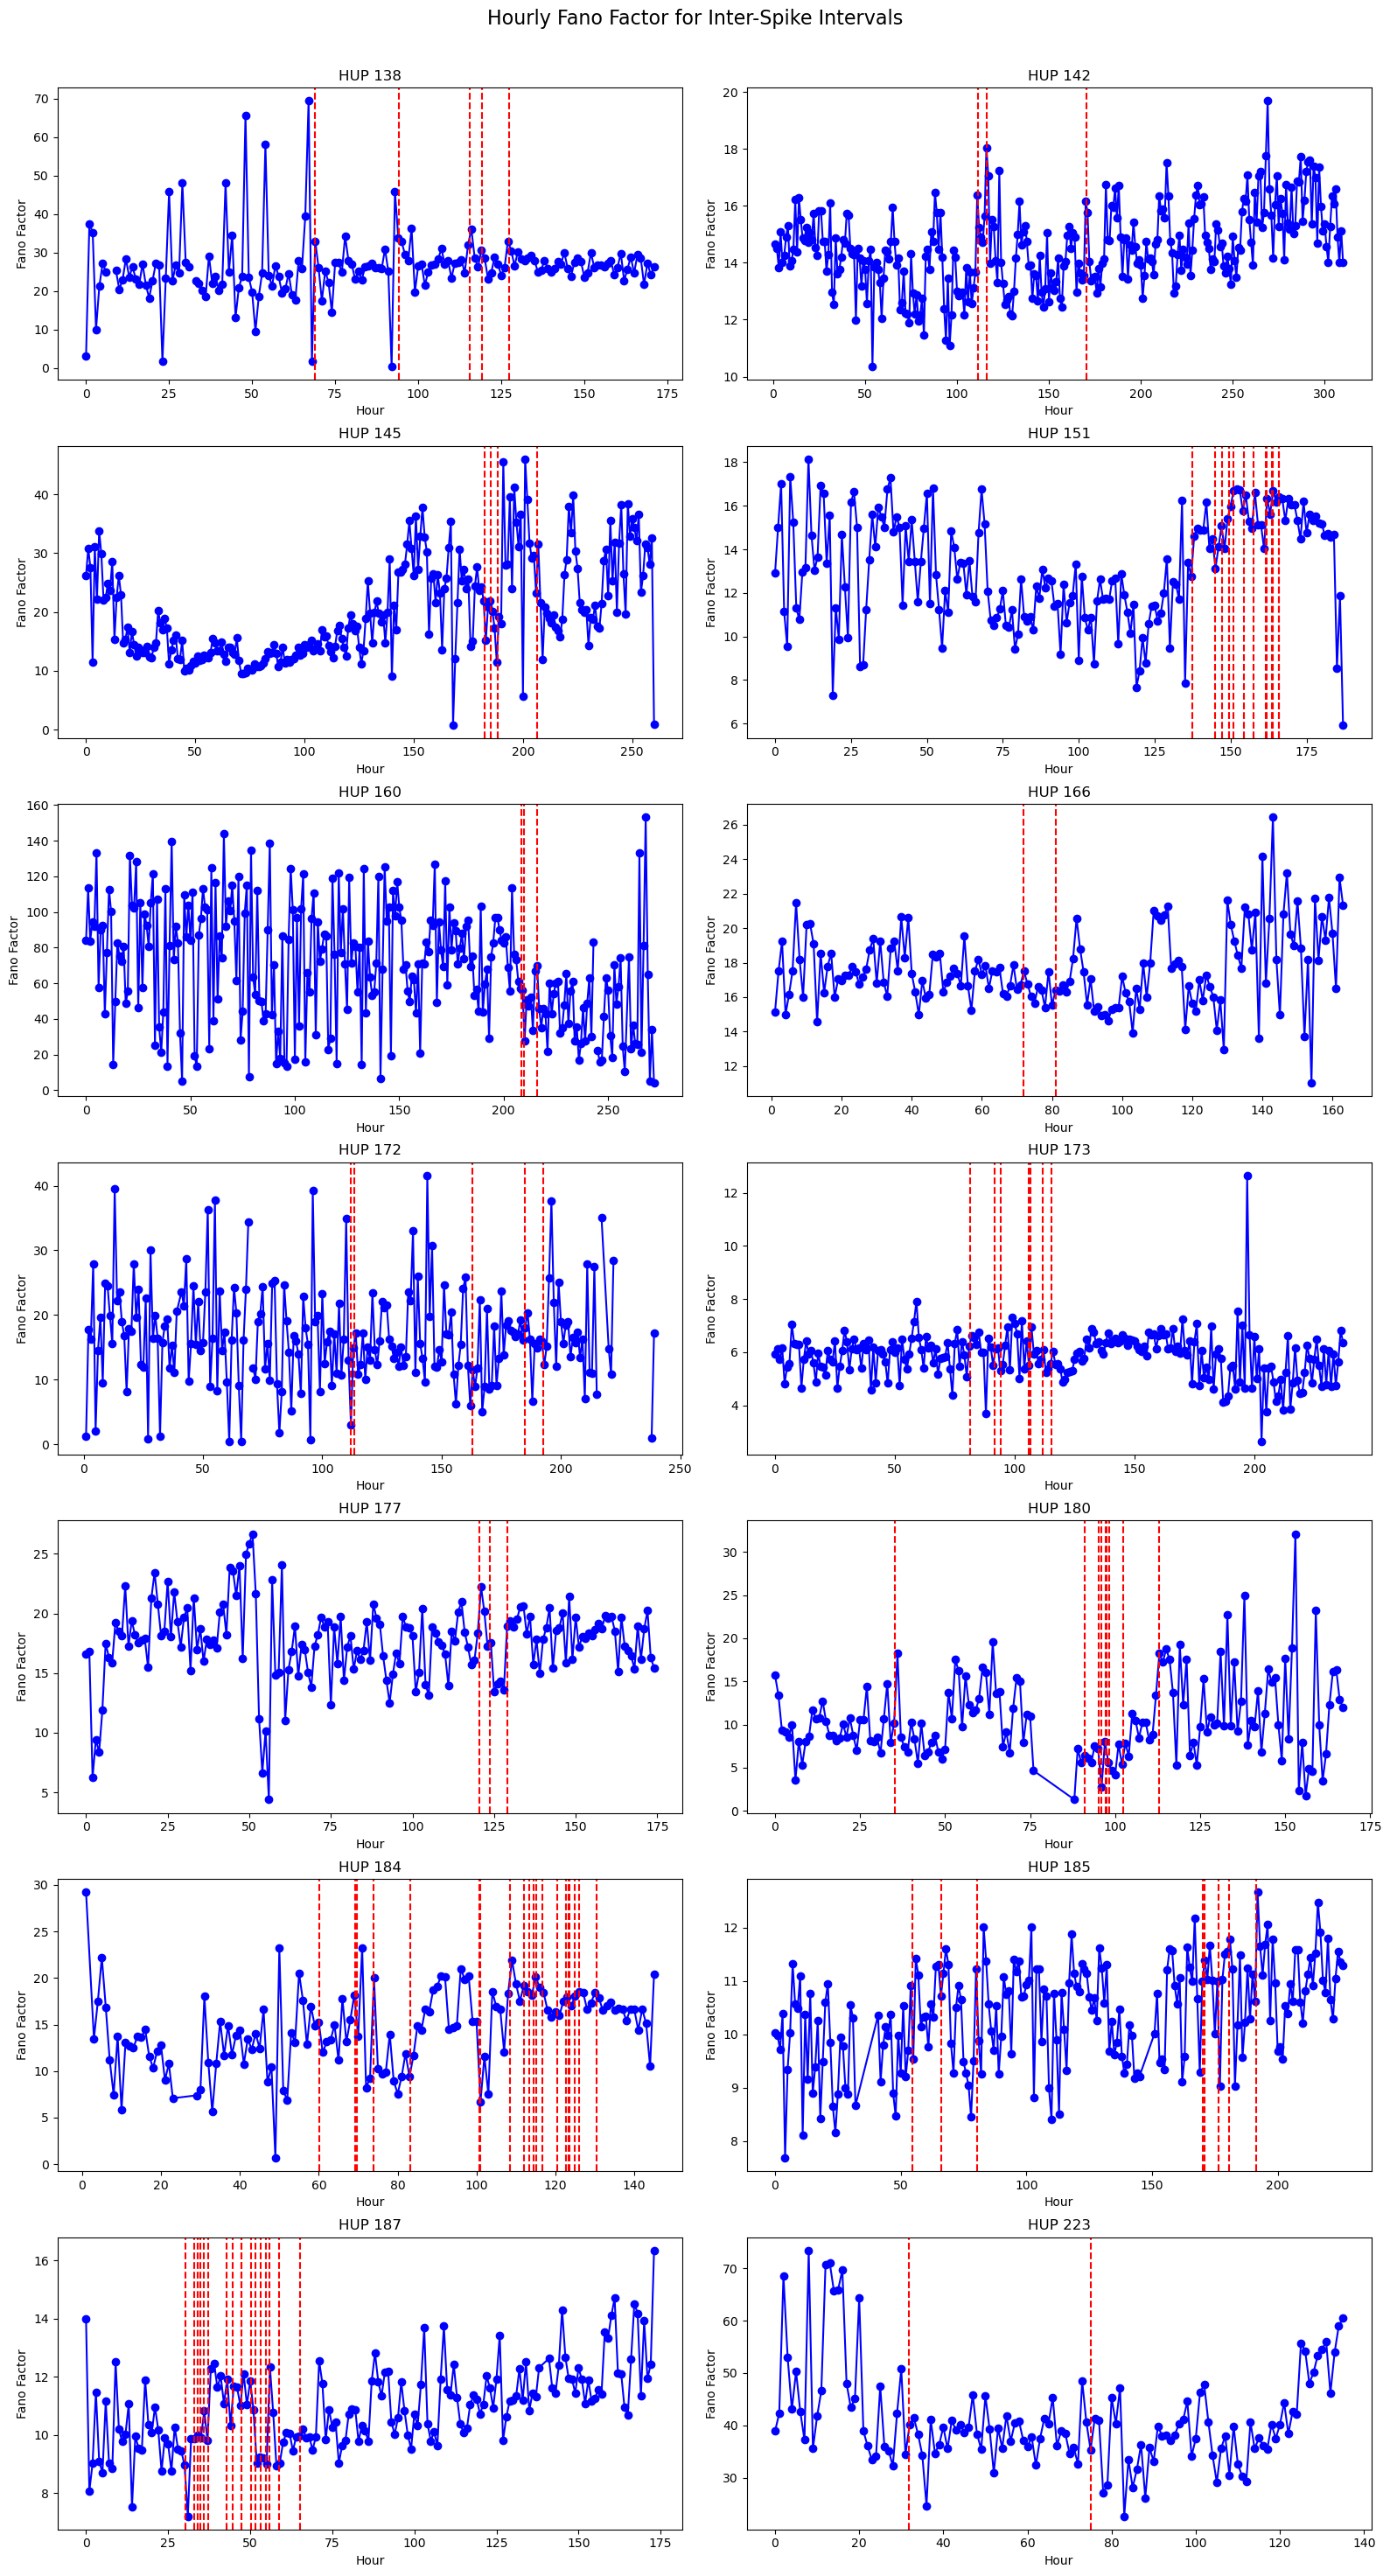

In [15]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

max_medication_fanos = []
before_seizure_fanos = []
after_seizure_fanos = []

# Looping over the dataframes
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    print(f"Processing HUP {hup_id}...")
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples < threshold]

    # Load seizure times and plot vertical lines
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours

    # Extracting Fano Factors for the three scenarios:

    # 1. Max medication
    max_medication_data = filtered_df[filtered_df["peak_hour"].isin(range(1, 13))][
        "inter_spike_interval_samples"
    ]
    max_medication_fano = max_medication_data.var() / max_medication_data.mean()
    max_medication_fanos.append(max_medication_fano)

    # 2. Before seizure
    first_seizure_hour = int(seizure_times_hour[0])
    before_seizure_data = filtered_df[
        filtered_df["peak_hour"].isin(
            range(first_seizure_hour - 4, first_seizure_hour + 1)
        )
    ]["inter_spike_interval_samples"]
    before_seizure_fano = before_seizure_data.var() / before_seizure_data.mean()
    before_seizure_fanos.append(before_seizure_fano)

    # 3. After seizure
    last_hours = sorted(filtered_df["peak_hour"].unique())[-9:-4]
    assert len(last_hours) == 5
    print(last_hours)
    after_seizure_data = filtered_df[filtered_df["peak_hour"].isin(last_hours)][
        "inter_spike_interval_samples"
    ]
    after_seizure_fano = after_seizure_data.var() / after_seizure_data.mean()
    after_seizure_fanos.append(after_seizure_fano)

    print(max_medication_fano, before_seizure_fano, after_seizure_fano)

    # Compute mean and variance by peak_hour
    grouped_mean = filtered_df.groupby("peak_hour")[
        "inter_spike_interval_samples"
    ].mean()
    grouped_variance = filtered_df.groupby("peak_hour")[
        "inter_spike_interval_samples"
    ].var()

    # Compute Fano Factor for each hour
    fano_factors = grouped_variance / grouped_mean

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting the Fano Factor
    axarr[row, col].plot(fano_factors.index, fano_factors, "-o", color="blue")

    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Fano Factor")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
# Add a title
fig.suptitle("Hourly Fano Factor for Inter-Spike Intervals", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

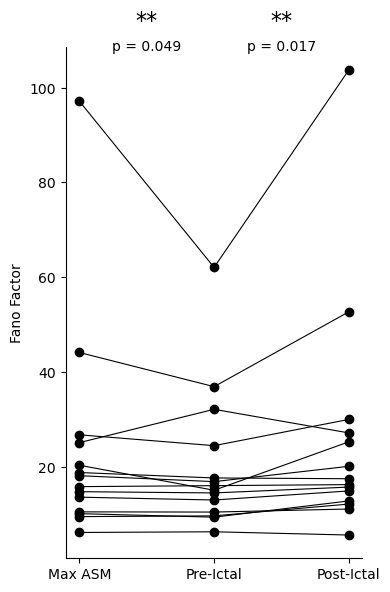

In [16]:
plt.figure(figsize=(4, 6))

for i in range(len(completed_hup_ids)):
    plt.plot(
        [0, 1, 2],
        [max_medication_fanos[i], before_seizure_fanos[i], after_seizure_fanos[i]],
        marker="o",
        color="black",
        linewidth=0.8,
    )

plt.xticks([0, 1, 2], ["Max ASM", "Pre-Ictal", "Post-Ictal"])
plt.ylabel("Fano Factor")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 3. Run statistical tests
w1, p1 = wilcoxon(max_medication_fanos, before_seizure_fanos)
w2, p2 = wilcoxon(before_seizure_fanos, after_seizure_fanos)

# Add p-values to the plot
significance_marker = "**"  # using a star as the significance marker
alpha = 0.05  # typical threshold for significance

if p1 < alpha:
    plt.text(
        0.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    0.5,
    plt.ylim()[1],
    f"p = {p1:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

if p2 < alpha:
    plt.text(
        1.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    1.5,
    plt.ylim()[1],
    f"p = {p2:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

plt.tight_layout()
plt.show()

## Large ISI Heterogenity and how it changes over time

Processing HUP 138...
[163.0, 164.0, 165.0, 166.0, 167.0]
1559859.0400709033 139966.53254904813 47677.865886356194
Processing HUP 142...
[302.0, 303.0, 304.0, 305.0, 306.0]
3398.4598323197265 6341.223605898195 2965.770345540984
Processing HUP 145...
[252.0, 253.0, 254.0, 255.0, 256.0]
4691.316793683151 19171.924619644677 14600.030673286868
Processing HUP 151...
[179.0, 180.0, 181.0, 182.0, 183.0]
83526.99036304827 15057.346414630258 1000.6741341854655
Processing HUP 160...


[264.0, 265.0, 266.0, 267.0, 268.0]
151020.3258427003 48615.75045133205 101894.3007775875
Processing HUP 166...
[155.0, 156.0, 157.0, 158.0, 159.0]
28844.891862249428 5804.845273000811 9238.425166923555
Processing HUP 172...
[222.0, 223.0, 224.0, 234.0, 235.0]
166234.53845048076 45938.649905309976 14979999.891488144
Processing HUP 173...
[229.0, 230.0, 231.0, 232.0, 233.0]
2263.766611421978 5740.700741854459 3093.487454315797
Processing HUP 177...
[166.0, 167.0, 168.0, 169.0, 170.0]
479486.30435826496 3436.61996381787 2762.6221237696964
Processing HUP 180...
[159.0, 160.0, 161.0, 162.0, 163.0]
58324.23813032804 7542.7853587242 46063.55974336963
Processing HUP 184...
[137.0, 138.0, 139.0, 140.0, 141.0]
586267.5344932178 21858.451527237008 585507.2064474345
Processing HUP 185...
[218.0, 219.0, 220.0, 221.0, 222.0]
149362.9206142436 6012.821645315583 1472.13682715823
Processing HUP 187...
[165.0, 166.0, 167.0, 168.0, 169.0]
64272.10723772341 6521.591728798267 3099.096094257697
Processing 

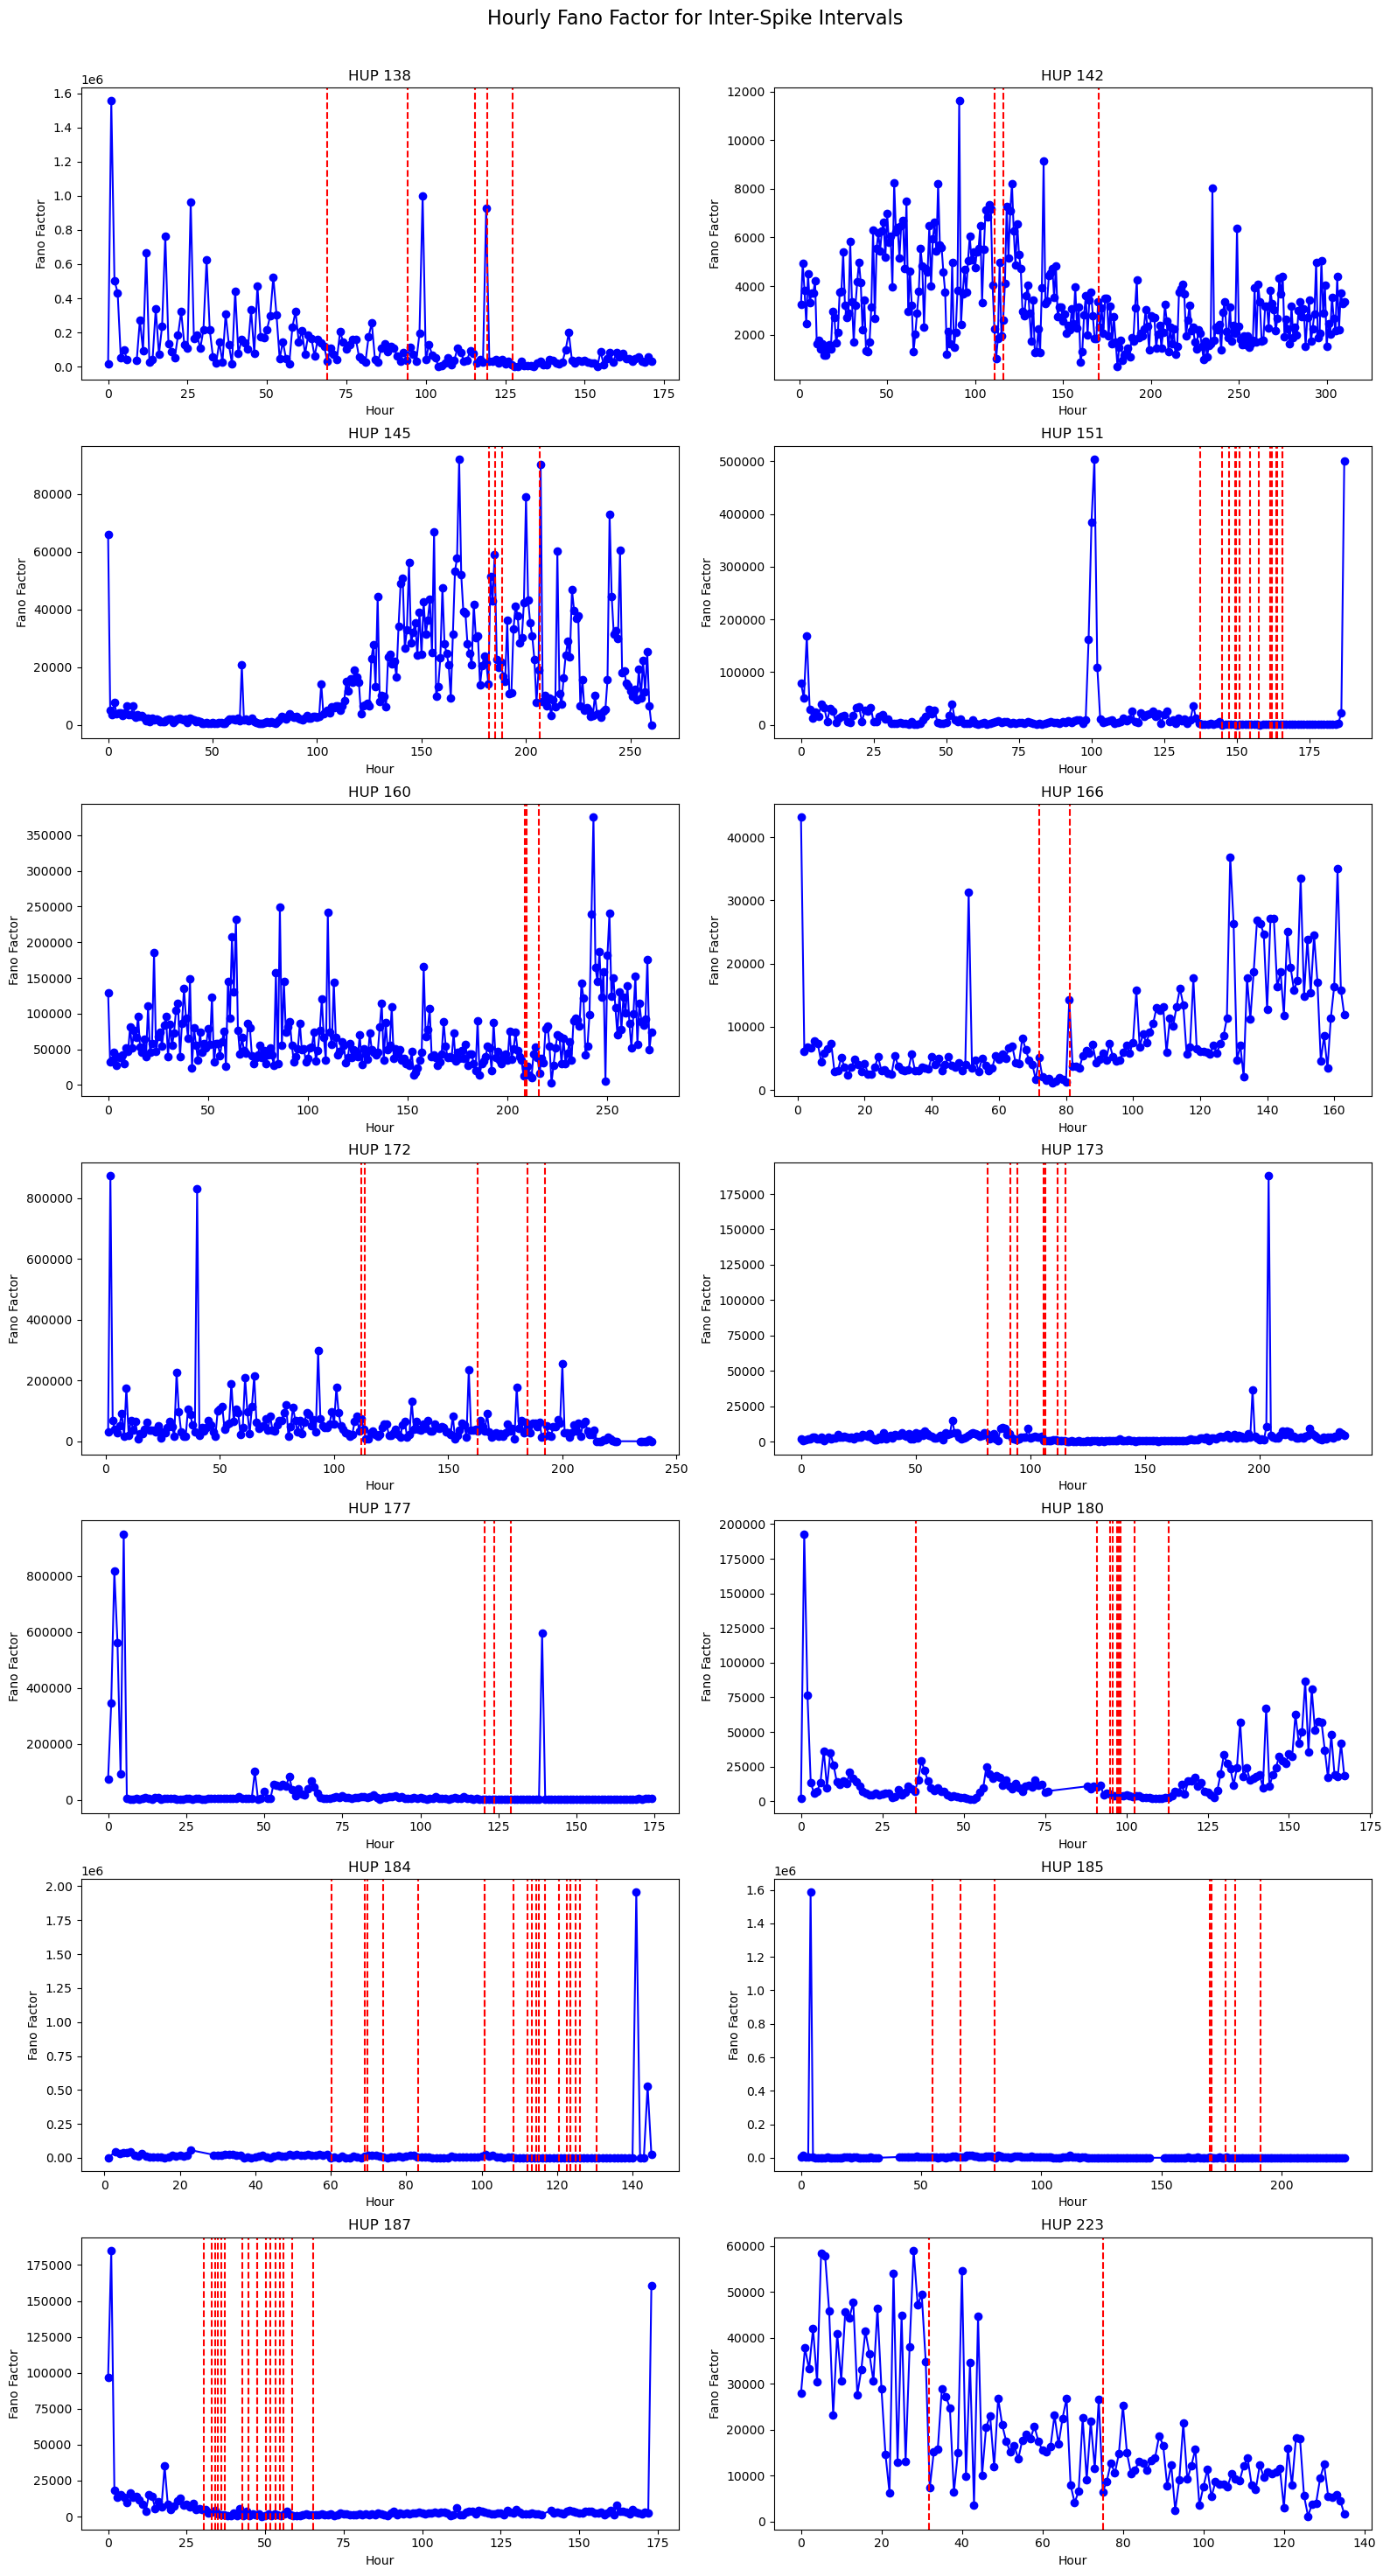

In [17]:
# Creating a subplot figure
n_patients = len(all_spikes_dfs)
fig, axarr = plt.subplots(
    nrows=(n_patients + 1) // 2, ncols=2, figsize=(16, 4 * (n_patients + 1) // 2)
)

max_medication_fanos = []
before_seizure_fanos = []
after_seizure_fanos = []

# Looping over the dataframes
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    print(f"Processing HUP {hup_id}...")

    # Filtering the rows
    filtered_df = all_spikes_df[
        all_spikes_df.inter_spike_interval_samples > threshold
    ].copy()

    # Load seizure times and plot vertical lines
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    seizure_times_hour = seizure_times_sec[:, 0] / 3600  # convert seconds to hours

    # 1. Max medication
    max_medication_data = filtered_df[filtered_df["peak_hour"].isin(range(1, 13))][
        "inter_spike_interval_samples"
    ]
    max_medication_fano = max_medication_data.var() / max_medication_data.mean()
    max_medication_fanos.append(max_medication_fano)

    # 2. Before seizure
    first_seizure_hour = int(seizure_times_hour[0])
    before_seizure_data = filtered_df[
        filtered_df["peak_hour"].isin(
            range(first_seizure_hour - 4, first_seizure_hour + 1)
        )
    ]["inter_spike_interval_samples"]
    before_seizure_fano = before_seizure_data.var() / before_seizure_data.mean()
    before_seizure_fanos.append(before_seizure_fano)

    # 3. After seizure
    last_hours = sorted(filtered_df["peak_hour"].unique())[-9:-4]
    assert len(last_hours) == 5
    print(last_hours)
    after_seizure_data = filtered_df[filtered_df["peak_hour"].isin(last_hours)][
        "inter_spike_interval_samples"
    ]
    after_seizure_fano = after_seizure_data.var() / after_seizure_data.mean()
    after_seizure_fanos.append(after_seizure_fano)

    print(max_medication_fano, before_seizure_fano, after_seizure_fano)

    # Drop the largest three values of the inter-spike intervals
    # Find the indices of the two largest inter_spike_interval_samples
    indices_to_drop = filtered_df["inter_spike_interval_samples"].nlargest(2).index
    # Drop those rows
    filtered_df.drop(indices_to_drop, inplace=True)
    # Reset the index
    filtered_df.reset_index(inplace=True)

    # Compute mean and variance by peak_hour
    grouped_mean = filtered_df.groupby("peak_hour")[
        "inter_spike_interval_samples"
    ].mean()
    grouped_variance = filtered_df.groupby("peak_hour")[
        "inter_spike_interval_samples"
    ].var()

    # Compute Fano Factor for each hour
    fano_factors = grouped_variance / grouped_mean

    # Get the subplot index
    idx = completed_hup_ids.index(hup_id)
    row = idx // 2
    col = idx % 2

    # Plotting the Fano Factor
    axarr[row, col].plot(fano_factors.index, fano_factors, "-o", color="blue")

    for seizure_time in seizure_times_hour:
        axarr[row, col].axvline(x=seizure_time, color="red", linestyle="--")

    axarr[row, col].set_title(f"HUP {hup_id}")
    axarr[row, col].set_xlabel("Hour")
    axarr[row, col].set_ylabel("Fano Factor")

# Delete unused subplots
for i in range(n_patients, 2 * ((n_patients + 1) // 2)):
    row = i // 2
    col = i % 2
    fig.delaxes(axarr[row, col])

plt.tight_layout()
# Add a title
fig.suptitle("Hourly Fano Factor for Inter-Spike Intervals", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

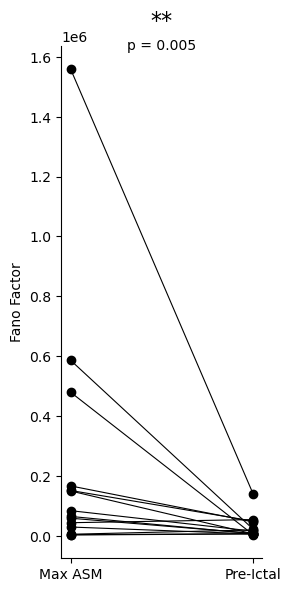

In [18]:
plt.figure(figsize=(3, 6))

for i in range(len(completed_hup_ids)):
    plt.plot(
        [0, 1],
        [max_medication_fanos[i], before_seizure_fanos[i]],
        marker="o",
        color="black",
        linewidth=0.8,
    )

plt.xticks([0, 1], ["Max ASM", "Pre-Ictal"])
plt.ylabel("Fano Factor")

# Remove the top and right borders
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 3. Run statistical tests
w1, p1 = wilcoxon(max_medication_fanos, before_seizure_fanos)
w2, p2 = wilcoxon(before_seizure_fanos, after_seizure_fanos)

# Add p-values to the plot
significance_marker = "**"  # using a star as the significance marker
alpha = 0.05  # typical threshold for significance

if p1 < alpha:
    plt.text(
        0.5,
        1.05 * plt.ylim()[1],
        significance_marker,
        horizontalalignment="center",
        verticalalignment="center",
        color="black",
        fontsize=16,
    )
plt.text(
    0.5,
    plt.ylim()[1],
    f"p = {p1:.3f}",
    horizontalalignment="center",
    verticalalignment="center",
)

plt.tight_layout()
plt.show()

## ASM taper period paths

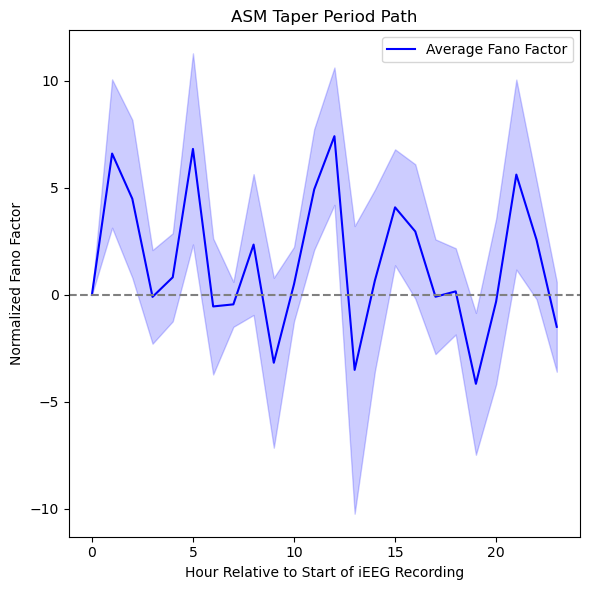

In [19]:
n_patients = len(all_spikes_dfs)
fano_values = []

# Looping over the dataframes
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples < threshold]

    fano_per_patient = []

    for hour in range(24):
        data_hour = filtered_df[filtered_df["peak_hour"] == hour][
            "inter_spike_interval_samples"
        ]

        if not data_hour.empty:
            fano = data_hour.var() / data_hour.mean()
            fano_per_patient.append(fano)
        else:
            fano_per_patient.append(np.nan)

    # Normalizing
    fano_per_patient = np.array(fano_per_patient) - fano_per_patient[0]
    fano_values.append(fano_per_patient)

fano_values = np.array(fano_values)

# Compute the average and standard error for the Fano Factor at each time point
avg_fano = np.nanmean(fano_values, axis=0)
stderr_fano = np.nanstd(fano_values, axis=0) / np.sqrt(n_patients)

# Plot the average Fano Factor for the first 24 hours with a filled error bar

plt.figure(figsize=(6, 6))
x_vals = np.arange(24)  # Hours

# Use Seaborn's lineplot with error bands for added aesthetics
sns.lineplot(x=x_vals, y=avg_fano, label="Average Fano Factor", color="blue")
plt.fill_between(
    x_vals, avg_fano - stderr_fano, avg_fano + stderr_fano, alpha=0.2, color="blue"
)

plt.title("ASM Taper Period Path")
plt.xlabel("Hour Relative to Start of iEEG Recording")
plt.ylabel("Normalized Fano Factor")
plt.axhline(0, color="grey", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()

## Pre-ictal paths

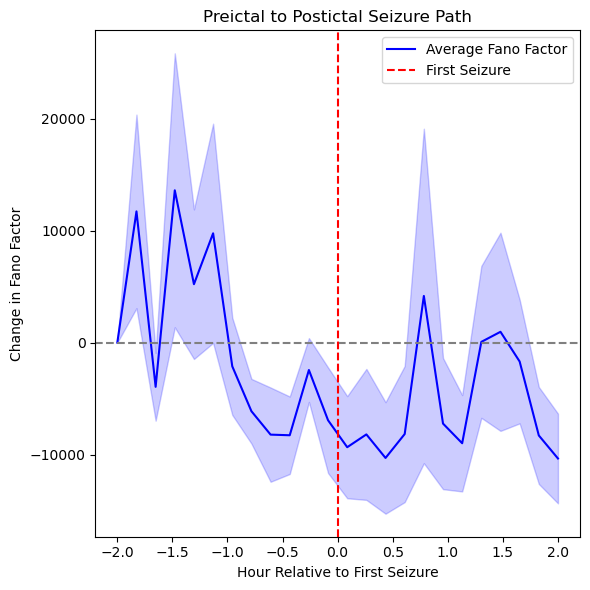

In [26]:
# Calculate Fano Factor for each patient around the first seizure
all_fano_factors = []

for all_spikes_df, hup_id in zip(all_spikes_dfs, completed_hup_ids):
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    first_seizure_hour = seizure_times_sec[0, 0] / 3600  # convert seconds to hours
    first_seizure_minute = int(first_seizure_hour * 60)  # convert hours to minutes

    patient_fano_factors = []

    # 2 hours (120 minutes) before the seizure to 2 hours after, in 10-minute increments
    for start_min in range(first_seizure_minute - 120, first_seizure_minute + 120, 10):
        # Define the 10-minute window
        windowed_data = all_spikes_df[
            (all_spikes_df["peak_minute"] >= start_min)
            & (all_spikes_df["peak_minute"] < start_min + 10)
        ]["inter_spike_interval_samples"]

        fano = windowed_data.var() / windowed_data.mean()
        patient_fano_factors.append(fano)

    # Normalize to hour -2 value
    patient_fano_factors = [f - patient_fano_factors[0] for f in patient_fano_factors]

    all_fano_factors.append(patient_fano_factors)

# Averaging across all patients
avg_fano = np.nanmean(all_fano_factors, axis=0)
stderr_fano = np.nanstd(all_fano_factors, axis=0) / np.sqrt(len(all_fano_factors))

# Plotting
plt.figure(figsize=(6, 6))
x_vals = np.linspace(-2, 2, len(avg_fano))
sns.lineplot(x=x_vals, y=avg_fano, label="Average Fano Factor", color="blue")
plt.fill_between(
    x_vals, avg_fano - stderr_fano, avg_fano + stderr_fano, alpha=0.2, color="blue"
)
plt.title("Preictal to Postictal Seizure Path")
plt.xlabel("Hour Relative to First Seizure")
plt.ylabel("Change in Fano Factor")
plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="red", linestyle="--", label="First Seizure")
plt.legend()
plt.tight_layout()
plt.show()

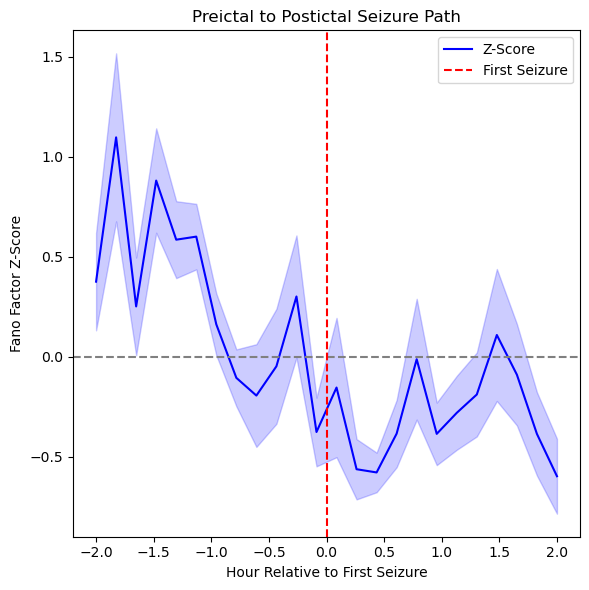

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os

# Calculate Fano Factor for each patient around the first seizure
all_fano_factors = []

for all_spikes_df, hup_id in zip(all_spikes_dfs, completed_hup_ids):
    seizure_times_sec = np.load(os.path.join(SEIZURES_DIR, f"HUP_{hup_id}.npy"))
    first_seizure_hour = seizure_times_sec[0, 0] / 3600  # convert seconds to hours
    first_seizure_minute = int(first_seizure_hour * 60)  # convert hours to minutes

    patient_fano_factors = []

    # 2 hours (120 minutes) before the seizure to 2 hours after, in 10-minute increments
    for start_min in range(first_seizure_minute - 120, first_seizure_minute + 120, 10):
        # Define the 10-minute window
        windowed_data = all_spikes_df[
            (all_spikes_df["peak_minute"] >= start_min)
            & (all_spikes_df["peak_minute"] < start_min + 10)
        ]["inter_spike_interval_samples"]

        fano = windowed_data.var() / windowed_data.mean()
        patient_fano_factors.append(fano)

    # Convert to z-scores
    patient_fano_factors = zscore(patient_fano_factors)

    all_fano_factors.append(patient_fano_factors)

# Averaging across all patients
avg_fano = np.nanmean(all_fano_factors, axis=0)
stderr_fano = np.nanstd(all_fano_factors, axis=0) / np.sqrt(len(all_fano_factors))

# Plotting
plt.figure(figsize=(6, 6))
x_vals = np.linspace(-2, 2, len(avg_fano))
sns.lineplot(x=x_vals, y=avg_fano, label="Z-Score", color="blue")
plt.fill_between(
    x_vals, avg_fano - stderr_fano, avg_fano + stderr_fano, alpha=0.2, color="blue"
)
plt.title("Preictal to Postictal Seizure Path")
plt.xlabel("Hour Relative to First Seizure")
plt.ylabel("Fano Factor Z-Score")
plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="red", linestyle="--", label="First Seizure")
plt.legend()
plt.tight_layout()
plt.show()

## ASM reinitiation paths

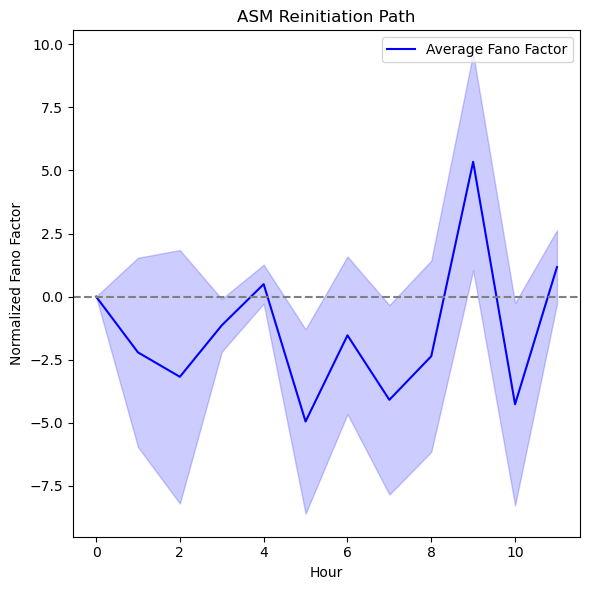

In [21]:
n_patients = len(all_spikes_dfs)
fano_values = []

# Looping over the dataframes
for all_spikes_df, fs, hup_id, threshold in zip(
    all_spikes_dfs, all_fs, completed_hup_ids, thresholds
):
    # Filtering the rows
    filtered_df = all_spikes_df[all_spikes_df.inter_spike_interval_samples < threshold]

    # Determine the last hour of the recording
    max_hour = int(filtered_df["peak_hour"].max())

    fano_per_patient = []

    # Loop from the last hour backward 24 hours
    for hour in range(max_hour - 16, max_hour - 4):
        data_hour = filtered_df[filtered_df["peak_hour"] == hour][
            "inter_spike_interval_samples"
        ]

        if not data_hour.empty:
            fano = data_hour.var() / data_hour.mean()
            fano_per_patient.append(fano)
        else:
            fano_per_patient.append(np.nan)

    # Normalizing
    fano_per_patient = np.array(fano_per_patient) - fano_per_patient[0]
    fano_values.append(fano_per_patient)

fano_values = np.array(fano_values)

# Compute the average and standard error for the Fano Factor at each time point
avg_fano = np.nanmean(fano_values, axis=0)
stderr_fano = np.nanstd(fano_values, axis=0) / np.sqrt(n_patients)

# Plot the average Fano Factor for the last 24 hours with a filled error bar
plt.figure(figsize=(6, 6))
x_vals = np.arange(12)  # Hours

# Use Seaborn's lineplot with error bands for added aesthetics
sns.lineplot(x=x_vals, y=avg_fano, label="Average Fano Factor", color="blue")
plt.fill_between(
    x_vals, avg_fano - stderr_fano, avg_fano + stderr_fano, alpha=0.2, color="blue"
)

plt.title("ASM Reinitiation Path")
plt.xlabel("Hour")
plt.ylabel("Normalized Fano Factor")
plt.axhline(0, color="grey", linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()